# Introduction
This notebook contains a working example to demonstrate detector-based saliency generation using `xaitk-saiency`'s `GenerateObjectDetectorBlackboxSaliency` high-level interface.

This example will follow an application-like use case, where we transform reference predictions belonging to a image into a number of saliency heatmaps based on our black-box detector's output, visualizing them over the input image.
The logic of this process is handled by the specified high-level interface implementation.

This will necessarily include the use of a detector model to perform the role of the black-box detector for which we will be determining the saliency.
We will fill this role here with a PyTorch, MSCOCO-pretrained, FasterRCNN-ResNet50 network.

### Table of Contents
* [Set Up Environment](#Set-Up-Environment)
* [The Test Image](#The-Test-Image)
* [The "Application"](#The-"Application")
* [Black-Box Detector](#Black-Box-Detector)
* [Saliency Generator](#Saliency-Generator)
* [Calling the Application](#Calling-the-Application)

### Miscellaneous

License for test image used may be found in 'COCO-LICENSE.txt'.

#### References
1. Petsiuk, Vitali, et al. "Black-box explanation of object detectors via saliency maps." Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition. 2021.

<br>

To run this notebook in Colab, use the link below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/XAITK/xaitk-saliency/blob/master/examples/DRISE.ipynb)

# Set Up Environment

In [1]:
import sys
print("Installing/updating pip...")
!{sys.executable} -m pip install -qU pip
print("Installing xaitk-saliency...")
!{sys.executable} -m pip install -q xaitk-saliency
print("Installing smqtk-detection[torch]...")
!{sys.executable} -m pip install -q smqtk-detection[torch]
print("Done!")

Installing/updating pip...
Installing xaitk-saliency...
Installing smqtk-detection[torch]...
Done!


# The Test Image
We will test this application on the following image.
We know that this image contains the MS-COCO classes of "dog" and "cat".

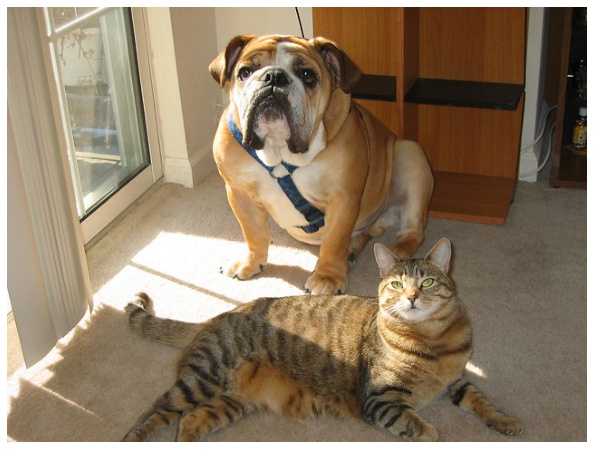

In [2]:
import PIL.Image
import matplotlib.pyplot as plt
import urllib.request


# Use JPEG format for inline visualizations here.
%config InlineBackend.figure_format = "jpeg"


# Test image to be explained
test_image_filename = 'data/catdog.jpg'
urllib.request.urlretrieve('https://farm1.staticflickr.com/74/202734059_fcce636dcd_z.jpg', test_image_filename)
plt.figure(figsize=(12, 8))
plt.axis('off')
_ = plt.imshow(PIL.Image.open(test_image_filename))

# The "Application"
First we will set up our application as a function with defined inputs for the following:
  * image
  * black-box detector
  * object detector saliency generator

The first two predictions returned by the input detector are used as reference detections for saliency generation.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
from typing import Optional, Sequence, Union
from xaitk_saliency import GenerateObjectDetectorBlackboxSaliency
from smqtk_detection import DetectImageObjects
import matplotlib.patches as patches


def app(
    image_filepath: str,
    blackbox_detector: DetectImageObjects,
    sal_map_generator: GenerateObjectDetectorBlackboxSaliency,
    fill: Optional[Union[int, Sequence[int]]] = None,
):
    # Load the image
    ref_image = np.asarray(PIL.Image.open(image_filepath))

    # Our reference detections are the first two predictions in the list
    img_preds = list(list(blackbox_detector([ref_image]))[0])
    ref_preds = img_preds[:2]
    
    # For the saliency heatmap generation API we need reference image detections
    # split into seperate bounding boxes and class score matrices    
    ref_bboxes = []
    ref_scores = []
    for det in ref_preds:
        bbox = det[0]
        ref_bboxes.append([
            *bbox.min_vertex,
            *bbox.max_vertex,
        ])

        score_dict = det[1]
        ref_scores.append(list(score_dict.values()))

    ref_bboxes = np.array(ref_bboxes)
    ref_scores = np.array(ref_scores)
    
    print(f"Ref bboxes: {ref_bboxes.shape}")
    print(f"Ref scores: {ref_scores.shape}")
    
    # Set our saliency generator to use the specified fill
    sal_generator.fill = fill
    
    sal_maps = sal_map_generator.generate(
        ref_image,
        ref_bboxes,
        ref_scores,
        blackbox_detector,
    )
    print(f"Saliency maps: {sal_maps.shape}")

    # Visualize the saliency heat-maps
    sub_plot_ind = len(sal_maps) + 1
    plt.figure(figsize=(12, 6))
    plt.subplot(2, sub_plot_ind, 1)
    plt.imshow(ref_image)
    plt.axis('off')
    plt.title('Test Image')

    # Some magic numbers here to get colorbar to be roughly the same height
    # as the plotted image.
    colorbar_kwargs = {
        "fraction": 0.046*(ref_image.shape[0]/ref_image.shape[1]),
        "pad": 0.04,
    }

    for i, det_sal_map in enumerate(sal_maps):
        print(f"Prediction {i + 1} saliency map range: [{det_sal_map.min()}, {det_sal_map.max()}]")

        # Saliency
        plt.subplot(2, sub_plot_ind, 2+i)
        plt.imshow(ref_image, alpha=0.7)
        plt.imshow(
            det_sal_map,
            cmap='jet', alpha=0.3
        )
        ax = plt.gca()
        bbox = ref_bboxes[i, 0:4]
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1],
                                 linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.colorbar(**colorbar_kwargs)
        plt.title(f"Prediction #{i+1} Saliency")
        plt.axis('off')

# Black-Box Detector
In this example we will use a PyTorch-based, pretrained, Faster-RCNN object detector with a ResNet50 backbone.
The `ResNetFRCNN` class from `SMQTK-Detection` provides this as a `smqtk_detection.DetectImageObjects` implementation, as required for use with the `GenerateObjectDetectorBlackboxSaliency` interface.
This model normally outputs a dictionary of predicted bounding boxes, scores, and labels.
However, this implementation monkey patches the bounding box `postprocess_detections` function to return probabilities for all classes. 
The [D-RISE](https://arxiv.org/abs/2006.03204) algorithm uses these class probabilities for computing similarity between reference and perturbed detections.

Note that the `use_cuda` parameter can be set to `True` if a CUDA device is available to reduce computation time.

In [4]:
from smqtk_detection.impls.detect_image_objects.resnet_frcnn import ResNetFRCNN

blackbox_detector = ResNetFRCNN(
    box_thresh=0.05,
    img_batch_size=1,
    use_cuda=True
)

model_mean = [0.485, 0.456, 0.406]
blackbox_fill = np.uint8(np.asarray(model_mean) * 255)

# Saliency Generator
Here we will instantiate our `GenerateObjectDetectorBlackboxSaliency` implementation that combines image perturbation and detector-based saliency map generation into one call.

We will use `DRISEStack` which is comprised of the `RISEGrid` and `DRISEScoring` image perturbation and saliency map generation methods, respectively.

In [5]:
from xaitk_saliency.impls.gen_object_detector_blackbox_sal.drise import DRISEStack

sal_generator = DRISEStack(200, 8, 0.5, seed=0, threads=4)

# Calling the Application
Here we will generate DRISE-based saliency maps using our helper function defined above.

## RISE Perturbation + DRISE

/home/local/KHQ/elim.schenck/anaconda3/envs/yolo/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/local/KHQ/elim.schenck/anaconda3/envs/yolo/lib/python3.9/site-packages/smqtk_detection/impls/detect_image_objects/resnet_frcnn.py:247: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  inds = inds // (num_classes - 1)


Ref bboxes: (2, 4)
Ref scores: (2, 80)
Saliency maps: (2, 480, 640)
Prediction 1 saliency map range: [0.9497073104181968, 1.0]
Prediction 2 saliency map range: [0.960576968910086, 1.0]


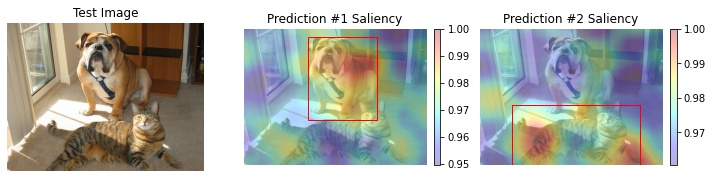

In [6]:
sal_maps = app(
    test_image_filename,
    blackbox_detector,
    sal_generator,
    fill=blackbox_fill,
)